# GloVE

Let's work on implementation of GloVE.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
import nltk
from nltk.corpus import reuters

In [3]:
# Check if CUDA is available and use GPU if yes
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
else:
    device = torch.device("cpu")   # Use CPU
    
print(device)

cuda


## 1. Load data

In [4]:
corpus = reuters.sents(categories="grain")
corpus

[['CHINA', 'DAILY', 'SAYS', 'VERMIN', 'EAT', '7', '-', '12', 'PCT', 'GRAIN', 'STOCKS', 'A', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume', 'between', 'seven', 'and', '12', 'pct', 'of', 'China', "'", 's', 'grain', 'stocks', ',', 'the', 'China', 'Daily', 'said', '.'], ['It', 'also', 'said', 'that', 'each', 'year', '1', '.', '575', 'mln', 'tonnes', ',', 'or', '25', 'pct', ',', 'of', 'China', "'", 's', 'fruit', 'output', 'are', 'left', 'to', 'rot', ',', 'and', '2', '.', '1', 'mln', 'tonnes', ',', 'or', 'up', 'to', '30', 'pct', ',', 'of', 'its', 'vegetables', '.'], ...]

### 1. Tokenization

In [5]:
from nltk.corpus import stopwords
import string
import re

# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Regular expression to match double punctuations
double_punctuation_pattern = re.compile(r'[' + re.escape(string.punctuation) + ']{2,}')

# Function to clean the corpus
def clean_corpus(corpus):
    cleaned_corpus = []
    for sentence in corpus:
        cleaned_sentence = []
        for word in sentence:
            word = word.lower()
            # Check for stopwords, punctuation, and double punctuation
            if word not in stop_words and word not in punctuation and not double_punctuation_pattern.match(word):
                cleaned_sentence.append(word)
        cleaned_corpus.append(cleaned_sentence)
    return cleaned_corpus

# Clean the corpus
cleaned_corpus = clean_corpus(corpus)
cleaned_corpus

[['china',
  'daily',
  'says',
  'vermin',
  'eat',
  '7',
  '12',
  'pct',
  'grain',
  'stocks',
  'survey',
  '19',
  'provinces',
  'seven',
  'cities',
  'showed',
  'vermin',
  'consume',
  'seven',
  '12',
  'pct',
  'china',
  'grain',
  'stocks',
  'china',
  'daily',
  'said'],
 ['also',
  'said',
  'year',
  '1',
  '575',
  'mln',
  'tonnes',
  '25',
  'pct',
  'china',
  'fruit',
  'output',
  'left',
  'rot',
  '2',
  '1',
  'mln',
  'tonnes',
  '30',
  'pct',
  'vegetables'],
 ['paper',
  'blamed',
  'waste',
  'inadequate',
  'storage',
  'bad',
  'preservation',
  'methods'],
 ['said',
  'government',
  'launched',
  'national',
  'programme',
  'reduce',
  'waste',
  'calling',
  'improved',
  'technology',
  'storage',
  'preservation',
  'greater',
  'production',
  'additives'],
 ['paper', 'gave', 'details'],
 ['thai',
  'trade',
  'deficit',
  'widens',
  'first',
  'quarter',
  'thailand',
  'trade',
  'deficit',
  'widened',
  '4',
  '5',
  'billion',
  'baht',


### 2. Numeralization

In [6]:
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(cleaned_corpus))) #all the words we have in the system - <UNK>

In [7]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index['fuel']

347

In [8]:
len(vocabs)

6965

In [9]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 6965

In [10]:
index2word = {v:k for k, v in word2index.items()}

In [11]:
index2word[6965],word2index['<UNK>']

('<UNK>', 6965)

## 2. Build Co-occurence Matrix X

Here, we need to count the co-occurence of two words given some window size.  We gonna use window size of 1.

In [12]:
from collections import Counter

X_i = Counter(flatten(cleaned_corpus))
X_i

Counter({'said': 1806,
         'tonnes': 1193,
         'mln': 1082,
         'wheat': 1006,
         'u': 909,
         '1': 740,
         '000': 721,
         'grain': 644,
         'corn': 587,
         '87': 575,
         '2': 526,
         'pct': 473,
         'year': 473,
         '0': 469,
         '1986': 411,
         'would': 395,
         '4': 380,
         '5': 366,
         'agriculture': 362,
         'dlrs': 361,
         'usda': 356,
         'last': 356,
         '3': 339,
         'nil': 326,
         'export': 314,
         'department': 302,
         'trade': 277,
         '1987': 274,
         'crop': 265,
         'soviet': 257,
         '7': 242,
         'week': 241,
         '8': 235,
         'production': 233,
         'market': 231,
         '6': 230,
         'prices': 228,
         '09': 226,
         '10': 220,
         'program': 220,
         'exports': 218,
         'farm': 215,
         'maize': 214,
         '1985': 213,
         'total': 207,
     

In [13]:
def skipgrams(corpus, window_size=2):
    skip_grams = []
    for doc in corpus:
        for i in range(window_size, len(doc) - window_size):
            center = doc[i]
            outside = []
            if i - window_size + 1 >= 0:
                outside.append(doc[i - window_size + 1])
            if i + window_size < len(doc):
                outside.append(doc[i + window_size])
            for each_out in outside:
                skip_grams.append((center, each_out))
    return skip_grams

In [14]:
window_size = 2
skip_grams = skipgrams(cleaned_corpus, window_size)
skip_grams

[('says', 'daily'),
 ('says', 'eat'),
 ('vermin', 'says'),
 ('vermin', '7'),
 ('eat', 'vermin'),
 ('eat', '12'),
 ('7', 'eat'),
 ('7', 'pct'),
 ('12', '7'),
 ('12', 'grain'),
 ('pct', '12'),
 ('pct', 'stocks'),
 ('grain', 'pct'),
 ('grain', 'survey'),
 ('stocks', 'grain'),
 ('stocks', '19'),
 ('survey', 'stocks'),
 ('survey', 'provinces'),
 ('19', 'survey'),
 ('19', 'seven'),
 ('provinces', '19'),
 ('provinces', 'cities'),
 ('seven', 'provinces'),
 ('seven', 'showed'),
 ('cities', 'seven'),
 ('cities', 'vermin'),
 ('showed', 'cities'),
 ('showed', 'consume'),
 ('vermin', 'showed'),
 ('vermin', 'seven'),
 ('consume', 'vermin'),
 ('consume', '12'),
 ('seven', 'consume'),
 ('seven', 'pct'),
 ('12', 'seven'),
 ('12', 'china'),
 ('pct', '12'),
 ('pct', 'grain'),
 ('china', 'pct'),
 ('china', 'stocks'),
 ('grain', 'china'),
 ('grain', 'china'),
 ('stocks', 'grain'),
 ('stocks', 'daily'),
 ('china', 'stocks'),
 ('china', 'said'),
 ('year', 'said'),
 ('year', '575'),
 ('1', 'year'),
 ('1', 'ml

In [15]:
skip_grams[:10]

[('says', 'daily'),
 ('says', 'eat'),
 ('vermin', 'says'),
 ('vermin', '7'),
 ('eat', 'vermin'),
 ('eat', '12'),
 ('7', 'eat'),
 ('7', 'pct'),
 ('12', '7'),
 ('12', 'grain')]

In [16]:
#count duplicateed words combinations
X_ik_skipgrams = Counter(skip_grams)
X_ik_skipgrams

Counter({('tonnes', '000'): 475,
         ('tonnes', 'mln'): 442,
         ('87', '09'): 381,
         ('nil', 'nil'): 308,
         ('87', '1986'): 232,
         ('03', '87'): 220,
         ('09', '03'): 217,
         ('04', '87'): 164,
         ('09', '04'): 163,
         ('agriculture', 'u'): 155,
         ('1', '1'): 147,
         ('u', 'department'): 134,
         ('1', 'mln'): 124,
         ('86', '1985'): 118,
         ('0', '0'): 109,
         ('2', '2'): 107,
         ('corn', 'u'): 100,
         ('department', 'agriculture'): 100,
         ('dlrs', 'mln'): 98,
         ('union', 'soviet'): 90,
         ('92', '0'): 86,
         ('year', 'last'): 83,
         ('agriculture', 'said'): 82,
         ('2', '4'): 81,
         ('2', 'mln'): 75,
         ('88', '1987'): 74,
         ('per', 'dlrs'): 70,
         ('tonne', 'per'): 70,
         ('mln', '0'): 68,
         ('mln', '5'): 66,
         ('wheat', 'tonnes'): 66,
         ('wheat', 'u'): 64,
         ('mln', 'vs'): 63,
       

In [17]:
#unique tokens
len(X_ik_skipgrams)

75865

### Weighting function

GloVe includes a weighting function to scale down too frequent words.

In [18]:
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [19]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function

for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgrams.get(bigram):  #if the pair exists in our corpus
        co = X_ik_skipgrams[bigram]
        X_ik[bigram] = co + 1 #for stability
        X_ik[(bigram[1], bigram[0])] = co + 1 #basically apple, banana = banana, apple
    else:
        pass
    
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

## 3. Prepare train data

In [20]:
import math

def random_batch(batch_size, word_sequence, X_ik, weighting_dic, window_size):
    
    skip_grams = skipgrams(word_sequence, window_size)
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [21]:
batch_size = 2
window_size = 2
x, y, cooc, weighting = random_batch(batch_size, cleaned_corpus, X_ik, weighting_dic, window_size)

In [22]:
x

array([[2862],
       [1736]])

In [23]:
y

array([[ 284],
       [4925]])

In [24]:
cooc

array([[0.        ],
       [1.60943791]])

In [25]:
weighting

array([[0.03162278],
       [0.10573713]])

## 4. Model

In [26]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

### Testing

In [27]:
#test our system
voc_size = len(vocabs)
emb_size = 2
model = Glove(voc_size, emb_size)

In [28]:
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)
cooc_tensor = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting)

In [29]:
loss = model(x_tensor, y_tensor, cooc_tensor, weighting_tensor)

In [30]:
loss

tensor(0.6032, grad_fn=<SumBackward0>)

## 5. Training

In [31]:
window_size    = 2
batch_size     = 10 # mini-batch size
emb_size = 2 #so we can later plot
voc_size       = len(vocabs) # vocabulary size
model          = Glove(voc_size, emb_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
import time

start_time = time.time()    
# Training
num_epochs = 1000
for epoch in range(num_epochs):
    
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, cleaned_corpus, X_ik, weighting_dic, window_size)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f}")
        
end_time = time.time()
    
total_time = start_time - end_time
min, sec = epoch_time(start_time, end_time)

print(f"Total loss: {loss:.6f} | time: {min} min {sec} sec")

Epoch: 100 | cost: 5.102532
Epoch: 200 | cost: 1.084106
Epoch: 300 | cost: 7.774431
Epoch: 400 | cost: 52.543571
Epoch: 500 | cost: 9.695049
Epoch: 600 | cost: 2.315360
Epoch: 700 | cost: 5.669093
Epoch: 800 | cost: 3.879224
Epoch: 900 | cost: 3.700121
Epoch: 1000 | cost: 8.504427
Total loss: 8.504427 | time: 1 min 9 sec


## 6. Plotting the embeddings

In [34]:
#list of vocabs
vocabs[:10]

['eight',
 'true',
 'non',
 'booked',
 'fresh',
 '106',
 '491',
 'complain',
 'drying',
 'industrial']

In [35]:
word = vocabs[0]

In [36]:
#numericalization
id = word2index[word]
id

0

In [37]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [38]:
#get the embedding by averaging
v_embed = model.center_embedding(id_tensor)
u_embed = model.outside_embedding(id_tensor)

v_embed, u_embed

(tensor([[ 0.7394, -0.6221]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.7772,  0.3771]], grad_fn=<EmbeddingBackward0>))

In [39]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed

tensor([[-0.0189, -0.1225]], grad_fn=<DivBackward0>)

In [40]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.center_embedding(id_tensor)
    u_embed = model.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

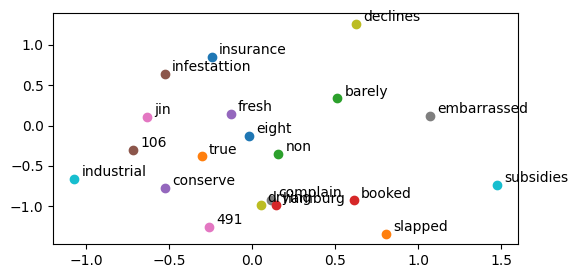

In [41]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [42]:
vocabs

['eight',
 'true',
 'non',
 'booked',
 'fresh',
 '106',
 '491',
 'complain',
 'drying',
 'industrial',
 'insurance',
 'slapped',
 'barely',
 'hamburg',
 'conserve',
 'infestattion',
 'jin',
 'embarrassed',
 'declines',
 'subsidies',
 '691',
 '1550',
 'bringing',
 'planters',
 'timecharter',
 '842',
 'african',
 'ite',
 'houston',
 'santa',
 'inches',
 'nearer',
 'producers',
 'southwest',
 '870',
 'reluctant',
 'roughly',
 'saw',
 'nonrecourse',
 'shipped',
 'sod',
 'national',
 'yala',
 'reopen',
 'hss',
 'installations',
 'pesos',
 'citrus',
 'reported',
 'greek',
 'evnsvlle',
 'unloads',
 'actual',
 'especially',
 '224',
 'pork',
 'devastated',
 'mandatory',
 'inappropriately',
 'authorized',
 'projecting',
 '905',
 'inputs',
 'thous',
 'top',
 '63',
 'fulfil',
 'keeping',
 'inched',
 'suggesting',
 'weekly',
 'reflection',
 'wereng',
 'cottonseed',
 'extreme',
 'force',
 'intermittently',
 'begining',
 'determining',
 'arguments',
 'usuaually',
 'chemicals',
 'edition',
 'jan',
 'o

In [43]:
#let's try similarity between first and second, and second and third
fuel = get_embed('fuel')
dollar = get_embed('dollar')

In [44]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"fuel vs. dollar: ",          cos_sim(dollar, fuel))

fuel vs. dollar:  0.3310116877170532


In [45]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"fuel vs. dollar: ",          cos_sim(dollar, fuel))

fuel vs. dollar:  0.33101168771705325


# Task 2

In [46]:
torch.save(model.state_dict(), 'model/glove_scratch.pt')

In [47]:
Data = {
    'corpus': cleaned_corpus,
    'vocab': vocabs,
    'word2index': word2index,
    'voc_size': voc_size,
    'embedding_size': emb_size
}

In [48]:
import pickle

In [49]:
pickle.dump(Data,open('model/glove_scratch_metadata.pkl', 'wb'))